## Prueba de modelos ##

### Version 3: Modelo con 2 DER, planificación anual, granularidad horaria ###

Si el modelo tiene que optimizar el balance por horas, tiene 8640 VD, pero sigue teniendo 2 VD binarias

In [1]:
import pandapower as pp

In [2]:
import os

In [3]:
import pandas as pd

In [4]:
import pyomo.environ as pe

In [5]:
import math

In [6]:
import random

In [7]:
import matplotlib.pyplot as plt

In [8]:
os.environ['NEOS_EMAIL'] = 'juan.manuel.sardon@gmail.com'

In [9]:
net = pp.create_empty_network() 
b1 = pp.create_bus(net, vn_kv=13.2)
b2 = pp.create_bus(net, vn_kv=13.2)
b3 = pp.create_bus(net, vn_kv=13.2)
b4 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b2, to_bus=b3, length_km=1.2, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b3, to_bus=b4, length_km=1.0, std_type="NAYY 4x50 SE")

pp.create_ext_grid(net, bus=b1)

pp.create_load(net, bus=b3, p_mw=0.350)

0

In [10]:
 pp.runpp(net)

In [11]:
print(net.res_bus.vm_pu)
print(net.res_line)

0    1.000000
1    0.998977
2    0.997436
3    0.997439
Name: vm_pu, dtype: float64
      p_from_mw  q_from_mvar       p_to_mw     q_to_mvar         pl_mw  \
0  3.509116e-01    -0.034250 -3.505460e-01  2.511060e-02  3.655632e-04   
1  3.505460e-01    -0.025111 -3.500001e-01  1.143635e-02  5.459089e-04   
2  1.210575e-07    -0.011436  3.942859e-11 -3.873803e-10  1.210970e-07   

    ql_mvar  i_from_ka       i_to_ka      i_ka  vm_from_pu  va_from_degree  \
0 -0.009140   0.015421  1.538744e-02  0.015421    1.000000        0.000000   
1 -0.013674   0.015387  1.535608e-02  0.015387    0.998977       -0.012683   
2 -0.011436   0.000501  1.707477e-11  0.000501    0.997436       -0.028839   

   vm_to_pu  va_to_degree  loading_percent  
0  0.998977     -0.012683        10.860096  
1  0.997436     -0.028839        10.836226  
2  0.997439     -0.030053         0.353167  


In [12]:
pp.create_sgen(net, b2, p_mw=0.05, q_mvar=0.025, max_p_mw=0.2, max_q_mvar=0.2)
pp.create_sgen(net, b4, p_mw=0.07, q_mvar=0.025, max_p_mw=0.3, max_q_mvar=0.2)


1

In [13]:
pp.runpp(net)

In [14]:
print(net.res_bus.vm_pu)
print(net.res_line)

0    1.000000
1    0.999351
2    0.998135
3    0.998408
Name: vm_pu, dtype: float64
   p_from_mw  q_from_mvar   p_to_mw  q_to_mvar     pl_mw   ql_mvar  i_from_ka  \
0   0.230553    -0.084334 -0.230378   0.075166  0.000175 -0.009168   0.010738   
1   0.280378    -0.050166 -0.280022   0.036453  0.000356 -0.013714   0.012466   
2  -0.069978    -0.036453  0.070000   0.025000  0.000022 -0.011453   0.003458   

    i_to_ka      i_ka  vm_from_pu  va_from_degree  vm_to_pu  va_to_degree  \
0  0.010606  0.010738    1.000000        0.000000  0.999351     -0.018512   
1  0.012374  0.012466    0.999351       -0.018512  0.998135     -0.038710   
2  0.003256  0.003458    0.998135       -0.038710  0.998408     -0.043302   

   loading_percent  
0         7.561657  
1         8.779012  
2         2.434919  


In [15]:
print(net)

This pandapower network includes the following parameter tables:
   - bus (4 elements)
   - load (1 element)
   - sgen (2 elements)
   - ext_grid (1 element)
   - line (3 elements)
 and the following results tables:
   - res_bus (4 elements)
   - res_line (3 elements)
   - res_ext_grid (1 element)
   - res_load (1 element)
   - res_sgen (2 elements)


In [16]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar
0,None,1,0.05,0.025,NaN,1.0,True,wye,True,0.2,0.2
1,None,3,0.07,0.025,NaN,1.0,True,wye,True,0.3,0.2


Agregamos los parámetros del modelo a los elementos de la red.

In [17]:
def net_add_optfw(net):
    #agregamos parámetros para el costo inicial en forma de un valor constante ic_0 y un valor función lineal de la potencia ic_1
    net.ext_grid['ic_0_mu'] = 0.0
    net.ext_grid['ic_1_mu'] = 0.0

    #idem para costo operativo
    net.ext_grid['oc_0_mu'] = 0.0
    net.ext_grid['oc_1_mu'] = 0.0

    #potencia disponible
    net.ext_grid['ap_mw'] = 1.0
    
    #potencia entregada
    net.ext_grid['op_mw'] = 0.0
    
    #las restricciones pueden ser ninguna, o una lista de restricciones tipo pyomo
    net.ext_grid['constraints'] = None

    #se repite para la carga y los generadores estáticos
    net.load['ic_0_mu'] = 0.0
    net.load['ic_1_mu'] = 0.0
    net.load['oc_0_mu'] = 0.0
    net.load['oc_1_mu'] = 0.0
    net.load['ap_mw'] = 0.5
    net.load['op_mw'] = 0.0
    net.load['constraints'] = None

    net.sgen['ic_0_mu'] = 0.0
    net.sgen['ic_1_mu'] = 0.0
    net.sgen['oc_0_mu'] = 0.0
    net.sgen['oc_1_mu'] = 0.0
    net.sgen['ap_mw'] = 0.5
    net.sgen['op_mw'] = 0.0
    net.sgen['constraints'] = None

In [18]:
net_add_optfw(net)

Vemos como queda por ejemplo el elemento de red externa:

In [19]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,ap_mw,op_mw,constraints
0,None,0,1.0,0.0,True,0.0,0.0,0.0,0.0,1.0,0.0,None


Defino una función normal de Python para que nos va a dar la componente lineal del costo de la energía

Variables que define el modelo:

y para el año

d para el día del año

h para la hora del día

dt la granularidad del modelo, en horas


temp la temperatura

wv la velocidad del viento

I la irradiación solar


eg el crecimiento económico en pu respecto al año 0


Estas variables llegan como parámetros en forma de diccionario en el argumento 'model_status' (ver este nombre)

Todas las funciones reciben este argumento, la lógica de la función indica que valor retorna. Pr ejemplo, si la granularidad es 24 h, debe retornar el valor medio del parámetro producido.

In [20]:
def oc_1_ext_grid(model_status={}):
    #modelo sencillo con dos precios, uno entre 0 a 18 y otro de 18 a 24
    res = 0.0
    sx = 1e-6
    if 'h' in model_status:
        h = model_status['h']
        if 0.0 <= h and h < 18.0:
            res = 3600.0*sx
        elif 18 <= h and h < 24.0:
            res = 5400.0*sx
        else:
            raise ValueError("Hour outside model range")
    else:
        raise ValueError("Hour not defined")
    
    return res

In [21]:
#test:
#m_s = {'y': 0, 'd': 180, 'h': 14.0, 'dt': 1.0, 'temp': 12.0, 'wv': 10.0, 'eg': 1.0}

#oc_1_ext_grid(m_s)

In [22]:
#20 hs: 5400
#m_s['h'] = 20.5
#oc_1_ext_grid(m_s)

In [23]:
#25 hs: error
#m_s['h'] = 25
#oc_1_ext_grid(m_s)

In [24]:
net.ext_grid['oc_1_mu'][0] = oc_1_ext_grid

In [25]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,ap_mw,op_mw,constraints
0,None,0,1.0,0.0,True,0.0,0.0,0.0,<function oc_1_ext_grid at 0x000002A2A6EC43A0>,1.0,0.0,None


In [26]:
def demand(model_status={}):
    #modelo sencillo en forma de escalones
    #devuelvr la fracción de la carga empleada
    #se considera que la carga tiene una variabilidad aleatoria de un 20% y es mayor en verano e invierno en un 30%
    #la variabilidad total puede ser 1.3*1.2=1.56 verano-invierno o 0.7*0.8 = 0.56 otoño-primavera, 
    res = 0.0
    if 'h' in model_status:
        h = model_status['h']
        if 0.0 <= h and h < 6.0:
            res = 0.2
        elif 6.0 <= h and h < 8.0:
            res = 0.4
        elif 8.0 <= h and h < 18.0:
            res = 0.5
        elif 18.0 <= h and h < 22.0:
            res = 1.0
        elif 22.0 <= h and h < 24.0:
            res = 0.3            
        else:
            raise ValueError("Hour outside model range")
    else:
        raise ValueError("Hour not defined")
    
    #estacionalidad
    if 'd' in model_status:
        d = model_status['d']
        #se asume que el día de mayor consumo es el inicio del verano y del invierno (21/12 y 21/07), por eso sumo 10 días el dia 0
        #divido por 180 porque hay dos picos en el año y paso a radianes
        estacionalidad = 1 + 0.3*math.cos((d + 10.0)/180.0*2*math.pi)  
    else:
        raise ValueError("Day not defined")
    res = res * estacionalidad
    
    #Aleatoriedad:
    res = res*random.uniform(0.8, 1.2)
    return res

In [27]:
net.load['op_mw'][0] = demand

In [28]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,ap_mw,op_mw,constraints
0,None,2,0.35,0.0,0.0,0.0,NaN,1.0,True,wye,0.0,0.0,0.0,0.0,0.5,<function demand at 0x000002A2A6EC4160>,None


In [29]:
def solar_output(model_status={}):
    #modelo sencillo
    #usando los datos de radiacion solar entregada por el modelo
    #considero el valor normal 1000 W/m2
    res = 0.0
    if 'I' in model_status:
        I = model_status['I']
        if 0.0 <= I and I < 1200:
            res = I / 1000.0
        else:
            raise ValueError("Solar radiation outside model range")
    else:
        raise ValueError("Solar radiation not defined")
    
    return res

In [30]:
#test:
##m_s = {'y': 0, 'd': 180, 'h': 43.0, 'dt': 1.0, 'temp': 12.0, 'I':950.0,  'wv': 10.0, 'eg': 1.0}
##solar_output(m_s)

In [31]:
net.sgen['name'][0] = 'PV1'
net.sgen['ap_mw'][0] = solar_output
net.sgen['ic_0_mu'][0] = 2
net.sgen['ic_1_mu'][0] = 0.75
net.sgen['oc_0_mu'][0] = 0.0
net.sgen['oc_1_mu'][0] = 500e-6


In [32]:
def wind_output(model_status={}):
    #modelo sencillo
    #devuelvr la fracción de la potencia entregada en función del tiempo
    #no toma en cuenta la radicación solar ni la temperatura
    res = 0.0
    if 'wv' in model_status:
        wv = model_status['wv']
        if 0.0 <= wv and wv < 3.0:
            res = 0.0
        elif 3.0 <= wv and wv < 15.0:
            res = (wv-3.0)/(15.0-3.0)
        elif 15.0 <= wv and wv < 25.0:
            res = 1.0
        else:
            res = 0.0
    else:
        raise ValueError("Wind Velocity not defined")
    
    return res

In [33]:
net.sgen['name'][1] = 'WT1'
net.sgen['ap_mw'][1] = wind_output
net.sgen['ic_0_mu'][1] = 5.0
net.sgen['ic_1_mu'][1] = 3.0
net.sgen['oc_0_mu'][1] = 0.0
net.sgen['oc_1_mu'][1] = 700e-6

In [34]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,ap_mw,op_mw,constraints
0,PV1,1,0.05,0.025,NaN,1.0,True,wye,True,0.2,0.2,2.0,0.75,0.0,0.0005,<function solar_output at 0x000002A2A6EC4820>,0.0,None
1,WT1,3,0.07,0.025,NaN,1.0,True,wye,True,0.3,0.2,5.0,3.00,0.0,0.0007,<function wind_output at 0x000002A2A6E93EE0>,0.0,None


Primero construyo un modelo manualmente:

Es un modelo de dimensionamiento de 2 DERs (WT+PV)

In [61]:
m = pe.ConcreteModel()

In [62]:
dias = 1
años = 1
M = 1e3

In [63]:
#el rango de horas:
T_i = range(24)

#el rango de dias:
Dias_i = range(dias)

Escenarios_i = range(len(T_i)*len(Dias_i))

In [64]:
#las variables que definien si construir y que potencia
m.ap_mw_PV = pe.Var(within = pe.NonNegativeReals)  #Tamano PV
m.ap_mw_WT = pe.Var(within = pe.NonNegativeReals)  #Tamano WT

m.sgen_PV = pe.Var(within = pe.Binary)
m.sgen_WT = pe.Var(within = pe.Binary) 

In [65]:
#despacho de solar y WT disponible
m.p_mw_PV = pe.Var(Escenarios_i, within = pe.NonNegativeReals)
m.p_mw_WT = pe.Var(Escenarios_i, within = pe.NonNegativeReals)

In [66]:
#energia comprada a la red
m.p_mw_Ext = pe.Var(Escenarios_i, within = pe.NonNegativeReals, bounds = (0, net.ext_grid['ap_mw'][0]))
#si puedo exportar:
##m.p_mw_Ext = pe.Var(T_i, bounds = (-net.ext_grid['ap_mw'][0], net.ext_grid['ap_mw'][0]))

In [67]:
def solar_irradiance_simulation(d, h):
    #simula las horas de sol, la intensidad y los dias multiplos de 5 esta nublado, con un 20% de la radiacion
    #a todo esto se le aplica una aleatoriedad del 80 al 100%
    #los coeficientes son aproximados para Buenos Aires
    radiacion = 1000.0
    
    estacionalidad = 0.75 + 0.25*math.cos((d + 10.0)/365.0*2*math.pi)  
    
    if d % 5 == 0 :
        nubosidad = 0.2
    else:
        nubosidad = 1.0
        
    aleatoriedad = random.uniform(0.8, 1.0)
    
    salida = 7.0 - 1.1*math.cos((d + 10.0)/365.0*2*math.pi)    #es una aproximacion, no basada en modelos matematicos
    puesta = 19.0 + 1.1*math.cos((d + 10.0)/365.0*2*math.pi)
    
    temporalidad = 0.0
    if salida <= h and h <= puesta:
        temporalidad = math.sin((h-salida)/(puesta-salida)*math.pi)
        
    return radiacion*estacionalidad*nubosidad*aleatoriedad*temporalidad

In [68]:
#solar_irradiance_simulation(176, 13)

In [69]:
m_s_base = [{'y': 0, 'd': 0, 'dd':1.0, 'h': 0.0, 'dt': 1.0, 'temp': 20.0, 'I':1000.0, 'wv': 10.0, 'eg': 1.0}]

registros = len(Dias_i)*len(T_i)

Escenarios =  pd.DataFrame(m_s_base, index = Escenarios_i)

reg = 0
for d in Dias_i:
    for h in T_i:
        Escenarios['d'][reg] = d
        Escenarios['h'][reg] = h
        Escenarios['I'][reg] = solar_irradiance_simulation(d, h)
        Escenarios['wv'][reg] = random.uniform(1.0, 20.0)
        reg += 1

In [70]:
Escenarios

,y,d,dd,h,dt,temp,I,wv,eg
0,0,0,1.0,0.0,1.0,20.0,0.000000,12.806443,1.0
1,0,0,1.0,1.0,1.0,20.0,0.000000,9.897077,1.0
2,0,0,1.0,2.0,1.0,20.0,0.000000,10.672301,1.0
3,0,0,1.0,3.0,1.0,20.0,0.000000,19.989347,1.0
4,0,0,1.0,4.0,1.0,20.0,0.000000,17.585246,1.0
5,0,0,1.0,5.0,1.0,20.0,0.000000,9.109582,1.0
6,0,0,1.0,6.0,1.0,20.0,3.052136,9.405939,1.0
7,0,0,1.0,7.0,1.0,20.0,38.288522,2.397203,1.0
8,0,0,1.0,8.0,1.0,20.0,79.939869,10.511976,1.0
9,0,0,1.0,9.0,1.0,20.0,108.837300,1.323374,1.0


In [71]:
#Escenarios_i

In [72]:
#los costos iniciales:
costos_iniciales = net.ext_grid['ic_0_mu'][0] + net.load['ic_0_mu'][0] + m.sgen_PV*net.sgen['ic_0_mu'][0] + m.sgen_WT*net.sgen['ic_0_mu'][1] +  \
                   net.ext_grid['ic_1_mu'][0]*0 + net.load['ic_1_mu'][0]*0 + m.ap_mw_PV * net.sgen['ic_1_mu'][0] + m.ap_mw_WT * net.sgen['ic_1_mu'][1]

In [73]:
print(costos_iniciales)

2.0*sgen_PV + 5.0*sgen_WT + 0.75*ap_mw_PV + 3.0*ap_mw_WT


In [74]:
costos_variables = sum(m.p_mw_PV[e]*net.sgen['oc_1_mu'][0]*Escenarios['dd'][e]*años+ m.p_mw_WT[e]*net.sgen['oc_1_mu'][1]*Escenarios['dd'][e]*años + m.p_mw_Ext[e]*net.ext_grid['oc_1_mu'][0](Escenarios.loc[e])*Escenarios['dd'][e]*años for e in Escenarios_i)

In [75]:
#print(costos_variables)

In [76]:
#costos = costos_iniciales + costos_variables

In [77]:
#print(costos)

In [78]:
m.value = pe.Objective(
expr = costos_iniciales + costos_variables,
sense = pe.minimize )

In [79]:
def hourly_power_balance(m, t):
    return m.p_mw_Ext[t] + m.p_mw_PV[t] + m.p_mw_WT[t] - net.load['op_mw'][0](Escenarios.loc[t])*net.load['p_mw'][0] == 0

In [80]:
m.hourly_power_balance = pe.Constraint(Escenarios_i, rule = hourly_power_balance)

In [81]:
#dimensionamiento solar:
m.PV_dim = pe.Constraint(Escenarios_i, rule = (lambda m, t : m.p_mw_PV[t] <= m.ap_mw_PV*net.sgen['ap_mw'][0](Escenarios.loc[t])))

In [82]:
m.PV_build = pe.Constraint( expr = m.ap_mw_PV <= m.sgen_PV*M)

In [83]:
#dimensionamiento WT:
m.WT_dim = pe.Constraint(Escenarios_i, rule = (lambda m, t : m.p_mw_WT[t] <= m.ap_mw_WT*net.sgen['ap_mw'][1](Escenarios.loc[t])))

In [84]:
m.WT_build = pe.Constraint( expr = m.ap_mw_WT <= m.sgen_WT*M)

In [85]:
#opt = pe.SolverFactory('glpk')
opt = pe.SolverFactory('cplex')
result_obj= opt.solve(m, tee=True)

#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(m, opt='cplex')




Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmprpeq2ozx.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmpt7_ji8ie.pyomo.lp' read.
Read time = 0.00 sec. (0.01 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmpt7_ji8ie.pyomo.lp
Objective sense      : Minimize
Variables            :      77  [Nneg: 51,  Box: 24,  Binary: 2]
Objective nonzeros   :      76
Linear constraints   :      75  [Less: 50,  Equal: 25]
  Nonzeros           :     161
  RHS nonzeros       :      25

Variables            : Min LB: 0.000000         Max UB: 1.000000       
Objective nonzeros   

In [86]:
m.pprint()

6 Set Declarations
    PV_dim_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
    WT_dim_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
    hourly_power_balance_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
    p_mw_Ext_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
    p_mw_PV_index : Size=1, Index=None, Ordered=False
       

In [74]:
getattr(m, 'value').expr()

17.865562198746623

In [75]:
getattr(m, 'sgen_WT').value

1.0

In [76]:
getattr(m, 'sgen_PV').value

0.0

In [77]:
getattr(m, 'ap_mw_WT').value

0.8390075068758223

In [78]:
getattr(m, 'p_mw_WT')[1005].value

0.322868746619411

In [79]:
getattr(m, 'p_mw_Ext')[8503].value

0.0

In [80]:
#Extracción de resultados en forma de Pandas Dataframe
Resultados =  pd.DataFrame([{'time': 0.0, 'p_mw_Ext': 0.0, 'p_mw_WT': 0.0, 'p_mw_PV':0.0, 'p_mw_Load':0.0}], index = Escenarios_i)

In [81]:
for e in Escenarios_i:
    esc = Escenarios.loc[e]
    Resultados['time'][e] = esc['d'] + esc['h']/24
    Resultados['p_mw_Ext'][e] = getattr(m, 'p_mw_Ext')[e].value
    Resultados['p_mw_PV'][e] = getattr(m, 'p_mw_PV')[e].value
    Resultados['p_mw_WT'][e] = getattr(m, 'p_mw_WT')[e].value
    #La información de la carga externa se pierde en el modelo, la tengo que reconstruir
    Resultados['p_mw_Load'][e] = Resultados['p_mw_Ext'][e] +  Resultados['p_mw_PV'][e] + Resultados['p_mw_WT'][e]
    

In [82]:
Resultados

,time,p_mw_Ext,p_mw_WT,p_mw_PV,p_mw_Load
0,0.000000,0.000000,0.089499,0.0,0.089499
1,0.041667,0.000000,0.088897,0.0,0.088897
2,0.083333,0.035331,0.062923,0.0,0.098254
3,0.125000,0.000000,0.076909,0.0,0.076909
4,0.166667,0.000000,0.095610,0.0,0.095610
...,...,...,...,...,...
8755,364.791667,0.000000,0.514903,0.0,0.514903
8756,364.833333,0.000000,0.360741,0.0,0.360741
8757,364.875000,0.391992,0.013647,0.0,0.405639
8758,364.916667,0.000000,0.154380,0.0,0.154380


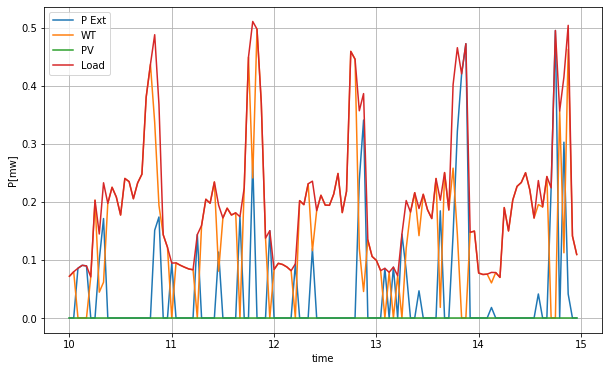

In [83]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
ax.plot(Resultados['time'][240:360], Resultados['p_mw_Ext'][240:360], label = 'P Ext')
ax.plot(Resultados['time'][240:360], Resultados['p_mw_WT'][240:360], label = 'WT')
ax.plot(Resultados['time'][240:360], Resultados['p_mw_PV'][240:360], label = 'PV')
ax.plot(Resultados['time'][240:360], Resultados['p_mw_Load'][240:360], label = 'Load')

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()